In [3]:
# ============================================================
# Leukemia Classification — 90%+ Targeted Pipeline
# EfficientNet-B3 | HybridLoss (CE+Focal) | AdamW | OneCycleLR | MixUp | TTA
# Clean logs: per-epoch loss/acc; detailed reports only for best Val + final Test
# ============================================================

import os, random
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# ----------------------- Reproducibility -----------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(42)
torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 2

# ============================================================
# 1) Datasets
# ============================================================
class LeukemiaDataset(Dataset):
    def __init__(self, root_dir, folds=None, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths, self.labels = [], []
        exts = ('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')

        if folds:
            for fold in folds:
                for label, category in enumerate(['all', 'hem']):
                    folder_path = os.path.join(root_dir, fold, category)
                    if not os.path.isdir(folder_path):
                        continue
                    for img_name in os.listdir(folder_path):
                        if img_name.lower().endswith(exts):
                            self.image_paths.append(os.path.join(folder_path, img_name))
                            self.labels.append(label)
        else:
            for label, category in enumerate(['all', 'hem']):
                folder_path = os.path.join(root_dir, category)
                if not os.path.isdir(folder_path):
                    continue
                for img_name in os.listdir(folder_path):
                    if img_name.lower().endswith(exts):
                        self.image_paths.append(os.path.join(folder_path, img_name))
                        self.labels.append(label)

    def __len__(self): return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


class LeukemiaCSVDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        if "new_names" not in self.data.columns or "labels" not in self.data.columns:
            raise ValueError("❌ CSV must contain 'new_names' and 'labels' columns.")
        self.filename_col = "new_names"
        print(f"✅ Using column '{self.filename_col}' for image names.")

    def __len__(self): return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, str(self.data.iloc[idx][self.filename_col]))
        image = Image.open(img_name).convert("RGB")
        label = int(self.data.iloc[idx]["labels"])
        if self.transform:
            image = self.transform(image)
        return image, label


# ============================================================
# 2) Transforms (RandomErasing after ToTensor ✅)
# ============================================================
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(300, scale=(0.6, 1.0), ratio=(0.9, 1.1), interpolation=InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(40),
    transforms.RandomAffine(degrees=0, translate=(0.20, 0.20), shear=10),
    transforms.ColorJitter(brightness=0.35, contrast=0.35, saturation=0.35, hue=0.05),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.GaussianBlur(3),
    transforms.ToTensor(),                # -> tensor before RandomErasing
    transforms.RandomErasing(p=0.5),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

transform_val = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.CenterCrop(300),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# ============================================================
# 3) Load & Split
# ============================================================
train_dir = "/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data"
val_dir   = "/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data"
val_csv   = "/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv"

train_raw = LeukemiaDataset(train_dir, folds=('fold_0', 'fold_1', 'fold_2'))
val_raw   = LeukemiaCSVDataset(val_csv, val_dir)

all_paths  = train_raw.image_paths + [os.path.join(val_dir, str(x)) for x in val_raw.data[val_raw.filename_col]]
all_labels = train_raw.labels      + list(val_raw.data["labels"])

train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_paths, all_labels, test_size=0.30, stratify=all_labels, random_state=42)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.50, stratify=temp_labels, random_state=42)

print("✅ Data Split Complete:")
print("Train:", Counter(train_labels))
print("Val:",   Counter(val_labels))
print("Test:",  Counter(test_labels))

# ------------------------------------------------------------
# Subset wrappers
# ------------------------------------------------------------
class SubsetDataset(Dataset):
    def __init__(self, paths, labels, transform):
        self.paths, self.labels, self.transform = paths, labels, transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        lbl = self.labels[idx]
        if self.transform: img = self.transform(img)
        return img, lbl

train_dataset = SubsetDataset(train_paths, train_labels, transform_train)
val_dataset   = SubsetDataset(val_paths,   val_labels,   transform_val)
test_dataset  = SubsetDataset(test_paths,  test_labels,  transform_val)

# NOTE: With FocalLoss we AVOID oversampling to prevent over-correction
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=2)



✅ Using column 'new_names' for image names.
✅ Data Split Complete:
Train: Counter({0: 5544, 1: 3225})
Val: Counter({0: 1188, 1: 691})
Test: Counter({0: 1188, 1: 692})


In [4]:
# ============================================================
# 4) Model — EfficientNet-B3 (better than ResNet50 here)
# ============================================================
weights = EfficientNet_B3_Weights.IMAGENET1K_V1
model = efficientnet_b3(weights=weights)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, NUM_CLASSES)
model = model.to(device)

# ============================================================
# 5) Losses — Focal + CE Hybrid (balanced)
# ============================================================
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=1.5):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce    = nn.CrossEntropyLoss(weight=alpha)

    def forward(self, logits, targets):
        ce = self.ce(logits, targets)
        pt = torch.exp(-ce)
        return ((1 - pt) ** self.gamma * ce).mean()

class HybridLoss(nn.Module):
    def __init__(self, alpha=None, gamma=1.5, ls=0.05, mix=0.5):
        super().__init__()
        self.focal = FocalLoss(alpha=alpha, gamma=gamma)
        self.ce    = nn.CrossEntropyLoss(weight=alpha, label_smoothing=ls)
        self.mix   = mix  # 0..1; 0.5 = balanced
    def forward(self, logits, targets):
        return self.mix * self.focal(logits, targets) + (1 - self.mix) * self.ce(logits, targets)

# class weights from training split (inverse freq)
train_counts = Counter(train_labels)
alpha_vec = torch.tensor([1.0/train_counts[i] for i in range(NUM_CLASSES)], device=device, dtype=torch.float32)
alpha_vec = alpha_vec / alpha_vec.sum() * NUM_CLASSES  # normalize
criterion = HybridLoss(alpha=alpha_vec, gamma=1.5, ls=0.05, mix=0.5)

# ============================================================
# 6) Optimizer + OneCycleLR (stable & strong)
# ============================================================
optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=0.02)
EPOCHS = 50
steps_per_epoch = len(train_loader)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=8e-4, epochs=EPOCHS, steps_per_epoch=steps_per_epoch,
    pct_start=0.15, div_factor=10.0, final_div_factor=100.0
)
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

# ============================================================
# 7) MixUp (simple, tensor-level)
# ============================================================
USE_MIXUP = True
MIXUP_ALPHA = 0.2

def mixup_data(x, y, alpha=MIXUP_ALPHA):
    if alpha <= 0:
        return x, y, 1.0
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size, device=x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion_fn, pred, y_a, y_b, lam):
    return lam * criterion_fn(pred, y_a) + (1 - lam) * criterion_fn(pred, y_b)

# ============================================================
# 8) TTA (Test-Time Augmentation) — average 4 simple views
# ============================================================
def tta_logits(model, images):
    # images: [B,C,H,W]
    outs = []
    # identity
    outs.append(model(images))
    # hflip
    outs.append(model(torch.flip(images, dims=[3])))
    # vflip
    outs.append(model(torch.flip(images, dims=[2])))
    # transpose H<->W
    outs.append(model(images.transpose(-1, -2)))
    # average
    return torch.stack(outs, dim=0).mean(0)

# ============================================================
# 9) Train/Eval Helpers
# ============================================================
def accuracy_from_logits(logits, targets):
    preds = torch.argmax(logits, dim=1)
    return (preds == targets).float().mean().item()

def train_one_epoch(model, loader, optimizer, scheduler):
    model.train()
    total_loss, total_acc, total_samples = 0.0, 0.0, 0

    for images, targets in tqdm(loader, leave=False):
        images, targets = images.to(device), targets.to(device)

        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            if USE_MIXUP and random.random() < 0.7:
                mixed_x, y_a, y_b, lam = mixup_data(images, targets, MIXUP_ALPHA)
                logits = model(mixed_x)
                loss = mixup_criterion(criterion, logits, y_a, y_b, lam)
                acc = accuracy_from_logits(logits, targets)  # rough acc on hard labels
            else:
                logits = model(images)
                loss = criterion(logits, targets)
                acc = accuracy_from_logits(logits, targets)

        bs = images.size(0)
        total_samples += bs
        total_loss += loss.item() * bs
        total_acc  += acc * bs

        optimizer.zero_grad(set_to_none=True)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

    return total_loss/total_samples, total_acc/total_samples

@torch.no_grad()
def evaluate(model, loader, split_name="Validation", verbose=False, use_tta=False):
    model.eval()
    total_loss, total_acc, total_samples = 0.0, 0.0, 0
    all_preds, all_targets = [], []

    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)

        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            if use_tta:
                logits = tta_logits(model, images)
            else:
                logits = model(images)
            loss = criterion(logits, targets)

        preds = torch.argmax(logits, dim=1)
        bs = images.size(0)
        total_samples += bs
        total_loss += loss.item() * bs
        total_acc  += (preds == targets).float().sum().item()

        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    if verbose:
        print(f"\n📋 {split_name} Classification Report:")
        print(classification_report(all_targets, all_preds, target_names=["ALL", "HEM"], digits=4))
        print(f"🧩 {split_name} Confusion Matrix:\n{confusion_matrix(all_targets, all_preds)}")

    return total_loss/total_samples, total_acc/total_samples, all_preds, all_targets

# ============================================================
# 10) Training Loop (clean output)
# ============================================================
best_val_acc, patience, no_improve = 0.0, 10, 0
ckpt_path = Path("./efficientnet_b3_leukemia_best.pth")

print("\n🚀 Training (EfficientNet-B3 + HybridLoss + OneCycleLR + MixUp)")
for epoch in range(1, EPOCHS + 1):
    print(f"\nEpoch {epoch}/{EPOCHS}")
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, scheduler)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, verbose=False, use_tta=False)
    print(f"Train Loss={tr_loss:.4f} | Val Loss={val_loss:.4f} | Val Acc={val_acc*100:.2f}% (Best={best_val_acc*100:.2f}%)")

    if val_acc > best_val_acc + 1e-4:
        best_val_acc = val_acc
        no_improve = 0
        torch.save(model.state_dict(), ckpt_path)
        print("✅ New Best Model Saved!")
        # Optional: show detailed best-val report (uncomment if you want it printed)
        # evaluate(model, val_loader, split_name="Best Validation", verbose=True, use_tta=True)
    else:
        no_improve += 1
        print(f"⏳ No improvement ({no_improve}/{patience})")
        if no_improve >= patience:
            print("🛑 Early stopping.")
            break

# ============================================================
# 11) Final Evaluation (Best Val + Test with TTA)
# ============================================================
print("\n🔁 Loading best checkpoint...")
model.load_state_dict(torch.load(ckpt_path, map_location=device))

# Best Validation (with TTA for a fair best-case look)
evaluate(model, val_loader,  split_name="Best Validation (TTA)", verbose=True, use_tta=True)

# Test (with TTA)
evaluate(model, test_loader, split_name="Test (TTA)", verbose=True, use_tta=True)


/tmp/ipykernel_37/1488233081.py:50: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())



🚀 Training (EfficientNet-B3 + HybridLoss + OneCycleLR + MixUp)

Epoch 1/50


  0%|          | 0/275 [00:00<?, ?it/s]/tmp/ipykernel_37/1488233081.py:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/tmp/ipykernel_37/1488233081.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Train Loss=0.4098 | Val Loss=0.3283 | Val Acc=76.37% (Best=0.00%)
✅ New Best Model Saved!

Epoch 2/50


Train Loss=0.3759 | Val Loss=0.3596 | Val Acc=65.14% (Best=76.37%)
⏳ No improvement (1/10)

Epoch 3/50


Train Loss=0.3665 | Val Loss=0.3177 | Val Acc=78.34% (Best=76.37%)
✅ New Best Model Saved!

Epoch 4/50


Train Loss=0.3606 | Val Loss=0.4488 | Val Acc=58.28% (Best=78.34%)
⏳ No improvement (1/10)

Epoch 5/50


Train Loss=0.3559 | Val Loss=0.3006 | Val Acc=78.02% (Best=78.34%)
⏳ No improvement (2/10)

Epoch 6/50


Train Loss=0.3451 | Val Loss=0.2892 | Val Acc=79.30% (Best=78.34%)
✅ New Best Model Saved!

Epoch 7/50


Train Loss=0.3416 | Val Loss=0.4807 | Val Acc=63.81% (Best=79.30%)
⏳ No improvement (1/10)

Epoch 8/50


Train Loss=0.3296 | Val Loss=0.3001 | Val Acc=78.13% (Best=79.30%)
⏳ No improvement (2/10)

Epoch 9/50


Train Loss=0.3340 | Val Loss=0.2745 | Val Acc=82.65% (Best=79.30%)
✅ New Best Model Saved!

Epoch 10/50


Train Loss=0.3216 | Val Loss=0.3796 | Val Acc=58.54% (Best=82.65%)
⏳ No improvement (1/10)

Epoch 11/50


Train Loss=0.3170 | Val Loss=0.3600 | Val Acc=72.33% (Best=82.65%)
⏳ No improvement (2/10)

Epoch 12/50


Train Loss=0.3152 | Val Loss=0.2579 | Val Acc=81.91% (Best=82.65%)
⏳ No improvement (3/10)

Epoch 13/50


Train Loss=0.3091 | Val Loss=0.8082 | Val Acc=53.11% (Best=82.65%)
⏳ No improvement (4/10)

Epoch 14/50


Train Loss=0.3010 | Val Loss=0.2386 | Val Acc=85.05% (Best=82.65%)
✅ New Best Model Saved!

Epoch 15/50


Train Loss=0.3031 | Val Loss=0.2701 | Val Acc=78.92% (Best=85.05%)
⏳ No improvement (1/10)

Epoch 16/50


Train Loss=0.3021 | Val Loss=0.2659 | Val Acc=74.93% (Best=85.05%)
⏳ No improvement (2/10)

Epoch 17/50


Train Loss=0.2929 | Val Loss=0.3111 | Val Acc=73.18% (Best=85.05%)
⏳ No improvement (3/10)

Epoch 18/50


Train Loss=0.2917 | Val Loss=0.2385 | Val Acc=80.63% (Best=85.05%)
⏳ No improvement (4/10)

Epoch 19/50


Train Loss=0.2904 | Val Loss=0.2545 | Val Acc=79.40% (Best=85.05%)
⏳ No improvement (5/10)

Epoch 20/50


Train Loss=0.2805 | Val Loss=0.2271 | Val Acc=84.62% (Best=85.05%)
⏳ No improvement (6/10)

Epoch 21/50


Train Loss=0.2787 | Val Loss=0.2344 | Val Acc=79.78% (Best=85.05%)
⏳ No improvement (7/10)

Epoch 22/50


Train Loss=0.2777 | Val Loss=0.2142 | Val Acc=85.15% (Best=85.05%)
✅ New Best Model Saved!

Epoch 23/50


Train Loss=0.2801 | Val Loss=0.2715 | Val Acc=77.43% (Best=85.15%)
⏳ No improvement (1/10)

Epoch 24/50


Train Loss=0.2703 | Val Loss=0.2010 | Val Acc=86.11% (Best=85.15%)
✅ New Best Model Saved!

Epoch 25/50


Train Loss=0.2694 | Val Loss=0.1923 | Val Acc=87.12% (Best=86.11%)
✅ New Best Model Saved!

Epoch 26/50


Train Loss=0.2624 | Val Loss=0.1912 | Val Acc=87.33% (Best=87.12%)
✅ New Best Model Saved!

Epoch 27/50


Train Loss=0.2613 | Val Loss=0.2880 | Val Acc=74.99% (Best=87.33%)
⏳ No improvement (1/10)

Epoch 28/50


Train Loss=0.2525 | Val Loss=0.2130 | Val Acc=81.64% (Best=87.33%)
⏳ No improvement (2/10)

Epoch 29/50


Train Loss=0.2485 | Val Loss=0.2528 | Val Acc=81.05% (Best=87.33%)
⏳ No improvement (3/10)

Epoch 30/50


Train Loss=0.2374 | Val Loss=0.2189 | Val Acc=83.24% (Best=87.33%)
⏳ No improvement (4/10)

Epoch 31/50


Train Loss=0.2387 | Val Loss=0.1991 | Val Acc=86.16% (Best=87.33%)
⏳ No improvement (5/10)

Epoch 32/50


Train Loss=0.2499 | Val Loss=0.1836 | Val Acc=89.46% (Best=87.33%)
✅ New Best Model Saved!

Epoch 33/50


Train Loss=0.2270 | Val Loss=0.1917 | Val Acc=86.59% (Best=89.46%)
⏳ No improvement (1/10)

Epoch 34/50


Train Loss=0.2389 | Val Loss=0.1927 | Val Acc=87.23% (Best=89.46%)
⏳ No improvement (2/10)

Epoch 35/50


Train Loss=0.2295 | Val Loss=0.2150 | Val Acc=84.09% (Best=89.46%)
⏳ No improvement (3/10)

Epoch 36/50


Train Loss=0.2268 | Val Loss=0.1886 | Val Acc=87.81% (Best=89.46%)
⏳ No improvement (4/10)

Epoch 37/50


Train Loss=0.2191 | Val Loss=0.1793 | Val Acc=88.24% (Best=89.46%)
⏳ No improvement (5/10)

Epoch 38/50


Train Loss=0.2188 | Val Loss=0.1741 | Val Acc=89.41% (Best=89.46%)
⏳ No improvement (6/10)

Epoch 39/50


Train Loss=0.2187 | Val Loss=0.1749 | Val Acc=87.97% (Best=89.46%)
⏳ No improvement (7/10)

Epoch 40/50


Train Loss=0.2084 | Val Loss=0.1669 | Val Acc=89.04% (Best=89.46%)
⏳ No improvement (8/10)

Epoch 41/50


Train Loss=0.2108 | Val Loss=0.1777 | Val Acc=89.04% (Best=89.46%)
⏳ No improvement (9/10)

Epoch 42/50


Train Loss=0.2176 | Val Loss=0.1793 | Val Acc=88.13% (Best=89.46%)
⏳ No improvement (10/10)
🛑 Early stopping.

🔁 Loading best checkpoint...

📋 Best Validation (TTA) Classification Report:
              precision    recall  f1-score   support

         ALL     0.9318    0.8965    0.9138      1188
         HEM     0.8329    0.8871    0.8591       691

    accuracy                         0.8930      1879
   macro avg     0.8823    0.8918    0.8865      1879
weighted avg     0.8954    0.8930    0.8937      1879

🧩 Best Validation (TTA) Confusion Matrix:
[[1065  123]
 [  78  613]]


/tmp/ipykernel_37/1488233081.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):



📋 Test (TTA) Classification Report:
              precision    recall  f1-score   support

         ALL     0.9192    0.9099    0.9146      1188
         HEM     0.8480    0.8627    0.8553       692

    accuracy                         0.8926      1880
   macro avg     0.8836    0.8863    0.8849      1880
weighted avg     0.8930    0.8926    0.8927      1880

🧩 Test (TTA) Confusion Matrix:
[[1081  107]
 [  95  597]]


(0.18172065920018135,
 0.8925531914893617,
 array([0, 1, 0, ..., 0, 0, 0]),
 array([0, 1, 0, ..., 0, 0, 0]))

/tmp/ipykernel_37/1488233081.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


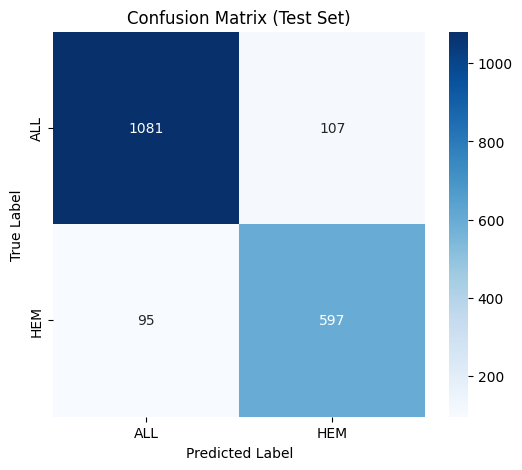

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Run the test evaluation again to get predictions and labels
_, _, test_preds, test_targets = evaluate(model, test_loader, split_name="Test (TTA)", verbose=False, use_tta=True)

# Compute confusion matrix
cm = confusion_matrix(test_targets, test_preds)
class_names = ["ALL", "HEM"]

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Test Set)")
plt.show()


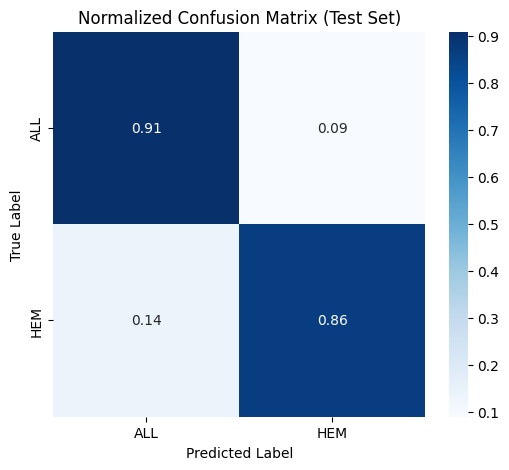

In [6]:
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix (Test Set)")
plt.show()


/tmp/ipykernel_37/1488233081.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


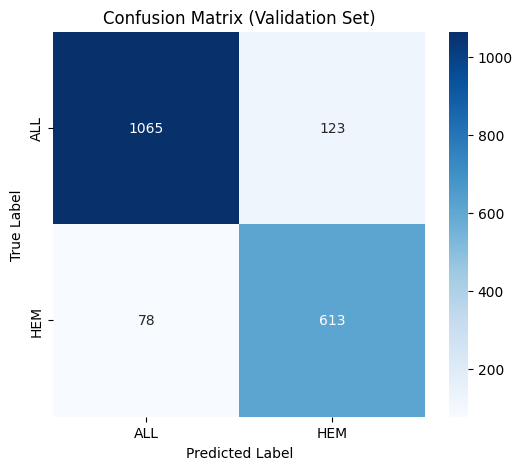

In [7]:
# Best Validation (with TTA)
_, _, val_preds, val_targets = evaluate(model, val_loader, split_name="Best Validation (TTA)", verbose=False, use_tta=True)

# Confusion Matrix (Validation)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm_val = confusion_matrix(val_targets, val_preds)
class_names = ["ALL", "HEM"]

plt.figure(figsize=(6,5))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Validation Set)")
plt.show()


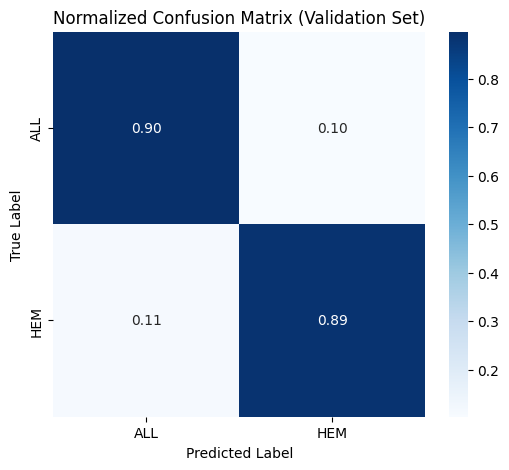

In [8]:
cm_val_norm = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6,5))
sns.heatmap(cm_val_norm, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix (Validation Set)")
plt.show()


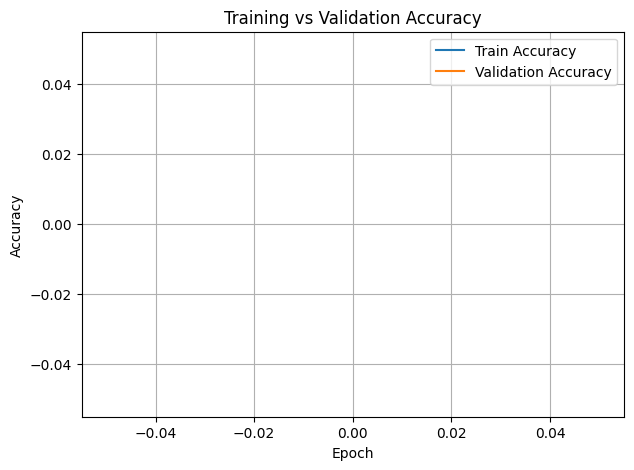

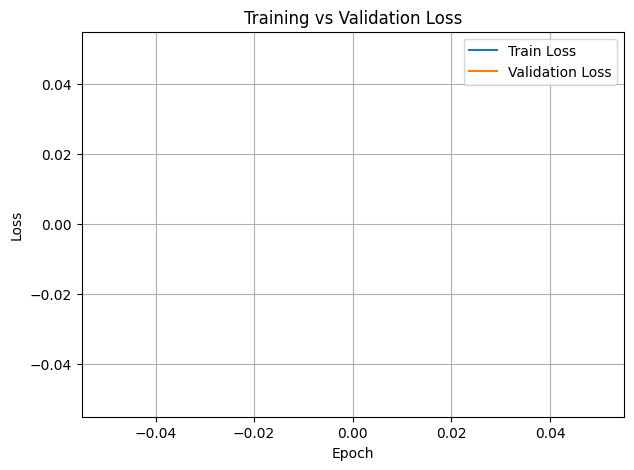

In [10]:
import matplotlib.pyplot as plt

# Accuracy Plot
plt.figure(figsize=(7,5))
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss Plot
plt.figure(figsize=(7,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
